# Importing Labraries

In [1]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import re
import locale
locale.setlocale(locale.LC_TIME, 'es_ES') # setting a local configuration for dates values

'es_ES'

# Functions

In this notebook we are going to build some functions to test the API.

In [121]:
df_movies = pd.read_csv("../processed_data/movies.csv")
df_cast = pd.read_csv("../processed_data/cast.csv")
df_crew = pd.read_csv("../processed_data/crew.csv")
actor_financial = pd.read_csv("../processed_data/actor_financial.csv")
director_financial = pd.read_csv("../processed_data/director_financial.csv")

This transformations are present in many functions, we will execute them now so the function doesn't have to do it every time.

In [122]:
df_movies["transformed_title"] = [x.lower().strip().replace(" ", "") for x in df_movies["title"]] # with pandas series, we need to use comprehension lists or apply()
df_movies["transformed_title"] = [unidecode(x) for x in df_movies["transformed_title"]]
df_movies["transformed_title"] = [re.sub(r'[^\w\s]', '', x) for x in df_movies["transformed_title"]]

In [123]:
actor_financial["transformed_name"] = [x.lower().strip().replace(" ", "") for x in actor_financial["name"]]  # with pandas series, we need to use comprehension lists or apply()
actor_financial["transformed_name"] = [unidecode(x) for x in actor_financial["transformed_name"]]
actor_financial["transformed_name"] = [re.sub(r'[^\w\s]', '', x) for x in actor_financial["transformed_name"]]  

## Amount of films by month

In [46]:
def cantidad_filmaciones_mes(month: str):
    if type(month) == str:
        month = month.lower().strip().replace(" ", "")
        month = unidecode(month)  # delete accents
        month = re.sub(r'[^\w\s]', '', month)  # delete special characters and punctuation marks
        # '%B' complete name of the month, strftime is string format time, it allows to format date data to a desirable representation
        # dt only works with pandas series that are datetime type
        df_movies["release_month"] = pd.to_datetime(df_movies["release_date"]).dt.strftime('%B')
        if month in df_movies["release_month"].unique():
            count_by_month = df_movies.groupby(["release_month"])["title"].count()
            return {month: count_by_month[month]}
        else:
            print("Entered value is not valid.")
    else:
        print("Entered value is not valid.")


In [47]:
cantidad_filmaciones_mes("+áBril")

{'abril': 3453}

In [48]:
# other option to get a dictionary with the answer

count_by_month = df_movies.groupby(["release_month"])["title"].count().reset_index()
index = (count_by_month["release_month"] == "abril" ).idxmax()
dict(count_by_month.loc[index, :])
 

{'release_month': 'abril', 'title': 3453}

In [5]:
df_movies["release_month"] = pd.to_datetime(df_movies["release_date"]).dt.strftime('%B') 
count_by_month = df_movies.groupby(["release_month"])["title"].count()
count_by_month

release_month
abril         3453
agosto        3394
diciembre     3784
enero         5910
febrero       3029
julio         2640
junio         3152
marzo         3553
mayo          3338
noviembre     3661
octubre       4613
septiembre    4836
Name: title, dtype: int64

## Amount of films by day of the week.

In [49]:
def cantidad_filmaciones_dia(day: str):
    if type(day) == str:
        day = day.lower().strip().replace(" ", "")
        day = unidecode(day) # delete accents
        day = re.sub(r'[^\w\s]', '', day) # delete special characters and punctuation marks
        # dt only works with pandas series that are datetime type
        # '%A' complete name of the day, strftime is string format time, it allows to format date data to a desirable representation
        df_movies["release_day"] = pd.to_datetime(df_movies["release_date"]).dt.strftime('%A') 
        if day in df_movies["release_day"].unique():
            count_by_day = df_movies.groupby(["release_day"])["title"].count()
            return {day:count_by_day[day]}
        else:
            print("Entered value is not valid.")
    else:
        print("Entered value is not valid.")
    

In [50]:
cantidad_filmaciones_dia("Viérnes-")

{'viernes': 13906}

In [8]:
df_movies["release_day"] = pd.to_datetime(df_movies["release_date"]).dt.strftime('%A') 
count_by_day = df_movies.groupby(["release_day"])["title"].count()
count_by_day 

release_day
domingo       3612
jueves        7522
lunes         3501
martes        4640
miércoles     7031
sábado        5151
viernes      13906
Name: title, dtype: int64

## Getting the popularity of a movie introducing the title.

There is a situation with the movies that have to be adressed here, there are duplicates for some movies because there are released in different languages. This function will get the popularity using idxmax() to get the index according to the title. idxmax() will consider only the first occurrence.

In [51]:
df_movies[df_movies["title"] == "12 Angry Men"]

,budget,id,original_language,overview,popularity,release_date,revenue,runtime,status,title,...,vote_count,collection,genres_list,spoken_languages_list,production_companies_list,production_countries_list,release_year,return,release_month,release_day
1159,350000.0,389,en,The defense and the prosecution have rested an...,16.503959,1957-03-25,1000000.0,96.0,Released,12 Angry Men,...,2130.0,NaN,['Drama'],['en'],"['United Artists', 'Orion-Nova Productions']",['US'],1957,2.857143,marzo,lunes
15189,0.0,12219,en,During the trial of a man accused of his fathe...,3.679263,1997-08-17,0.0,117.0,Released,12 Angry Men,...,59.0,NaN,"['Crime', 'Drama']","['en', 'hu', 'ru']",['MGM Television'],['US'],1997,0.000000,agosto,domingo


In [67]:
def score_titulo(title: str):
    if type(title) == str:
        title = title.lower().strip().replace(" ", "")
        title = unidecode(title) # delete accents
        title = re.sub(r'[^\w\s]', '', title) # delete special characters and punctuation marks
        if title in df_movies["transformed_title"].unique(): # there are repeated movies (different language)
            index = (df_movies["transformed_title"] == title).idxmax()
            return {"Title":df_movies["title"][index], "Year":df_movies["release_year"][index], "Popularity":df_movies["popularity"][index]} 
        else:
            print("Entered value is not valid.")
    else:
        print("Entered value is not valid.")

In [68]:
score_titulo("12angry, MEN")

{'Title': '12 Angry Men', 'Year': 1957, 'Popularity': 16.503959}

This function right here will group the title column and sum the popularity of every occurrence.

In [69]:
def score_titulo(title: str):
    if type(title) == str:
        title = title.lower().strip().replace(" ", "")
        title = unidecode(title)  # delete accents
        title = re.sub(r'[^\w\s]', '', title)  # delete special characters and punctuation marks      
        df_grouped = df_movies.groupby("transformed_title")["popularity"].sum()
        if title in df_grouped.index: # values of the grouped column are the new index in a grouped df
            normal_index = (df_movies["transformed_title"] == title).idxmax() # index for non transformed and non grouped values
            return {"Title": df_movies["title"][normal_index], "Year": df_movies["release_year"][normal_index], "Popularity" : df_grouped[title]} 
        else:
            print("Entered value is not valid.")
    else:
        print("Entered value is not valid.")


In [70]:
score_titulo("12angry MEN")

{'Title': '12 Angry Men', 'Year': 1957, 'Popularity': 20.183221999999997}

## Getting total votes and average vote of a movie.

Here we have to deal with same situation of the previous function. This is the solution usig idxmax().

In [72]:
def votos_titulo(title: str):
    if type(title) == str:
        title = title.lower().strip().replace(" ", "")
        title = unidecode(title) # delete accents
        title = re.sub(r'[^\w\s]', '', title) # delete special characters and punctuation marks
        if title in df_movies["transformed_title"].unique(): # there are repeated movies (different language) 
            index = (df_movies["transformed_title"] == title).idxmax()
            if df_movies["vote_count"][index] >= 2000:
                return {"Title": df_movies["title"][index], "Year": df_movies["release_year"][index], "Total votes": df_movies["vote_count"][index], "Average vote": df_movies["vote_average"][index]}
            else:
                print("Movie must have at least 2000 votes")
        else:
            print("Entered value is not valid.")
    else:
        print("Entered value is not valid.")

In [73]:
votos_titulo("12anGRY mén ")

{'Title': '12 Angry Men',
 'Year': 1957,
 'Total votes': 2130.0,
 'Average vote': 8.2}

In [74]:
votos_titulo("moonlight")

Movie must have at least 2000 votes


In [80]:
df_movies[df_movies["title"] == "Moonlight"] # checking the vote_count

,budget,id,original_language,overview,popularity,release_date,revenue,runtime,status,title,vote_average,vote_count,collection,genres_list,spoken_languages_list,production_companies_list,production_countries_list,release_year,return
39890,4000000.0,376867,en,"The tender, heartbreaking story of a young man...",14.171675,2016-10-21,65046687.0,111.0,Released,Moonlight,7.3,1831.0,NaN,['Drama'],['en'],"['Plan B Entertainment', 'Upload Films', 'A24'...",['US'],2016,16.261672


And this is the solution considering all the occurrences and using aggregation functions.

In [75]:
def votos_titulo(title: str):
    if type(title) == str:
        title = title.lower().strip().replace(" ", "")
        title = unidecode(title)  # delete accents
        title = re.sub(r'[^\w\s]', '', title)  # delete special characters and punctuation marks
        df_grouped_total = df_movies.groupby("transformed_title")["vote_count"].sum()
        df_grouped_average = df_movies.groupby("transformed_title")["vote_average"].mean()
        if title in df_grouped_average.index: # values of the grouped column are the new index in a grouped df
             if df_grouped_total[title] >= 2000:
                normal_index = (df_movies["transformed_title"] == title).idxmax() # index for non transformed and non grouped values
                return {"Title": df_movies["title"][normal_index], "Year": df_movies["release_year"][normal_index], "Total Votes" : df_grouped_total[title], "Average Vote" : df_grouped_average[title]}
             else:
                 print("Movie must have at least 2000 votes")
        else:
            print("Entered value is not valid.")    
    else:
        print("Entered value is not valid.")

In [76]:
votos_titulo("moonlight")

Movie must have at least 2000 votes


In [77]:
votos_titulo("12 angry, men")

{'Title': '12 Angry Men',
 'Year': 1957,
 'Total Votes': 2189.0,
 'Average Vote': 7.85}

## Getting return and number of movies of an actor.

In [126]:
def get_actor(name):
    if type(name) == str:
        name = name.lower().strip().replace(" ", "")
        name = unidecode(name)  # delete accents
        name = re.sub(r'[^\w\s]', '', name)  # delete special characters and punctuation marks
        if name in actor_financial["transformed_name"].unique():
            index = (actor_financial["transformed_name"] == name).idxmax()
            return {'actor':actor_financial["name"][index], 'films':actor_financial["films"][index], 'total return':actor_financial["total_return"][index], 'average return':actor_financial["average_return"][index]}        
        else:
            print("Entered value is not valid.")
    print("Entered value is not valid.")
   

In [127]:
get_actor("Johnnydépp")

{'actor': 'Johnny Depp',
 'films': 69,
 'total return': 2.7742222312961227,
 'average return': 2.02}


def get_director( nombre_director ): Se ingresa el nombre de un director que se encuentre dentro de un dataset debiendo devolver el éxito del mismo medido a través del retorno. Además, deberá devolver el nombre de cada película con la fecha de lanzamiento, retorno individual, costo y ganancia de la misma.

In [126]:
director_df = df_crew[df_crew["job"] == "Director"]

In [127]:
join_director = df_movies.merge(director_df[["id", "name"]], how="left", on="id") 
budget_director = join_director.groupby("name")["budget"].sum().sort_values(ascending=False).reset_index()
revenue_director = join_director.groupby("name")["revenue"].sum().sort_values(ascending=False).reset_index()
final_join = budget_director.merge(revenue_director, how="left", on="name")

In [129]:
final_join["return"] = np.where(final_join["budget"] != 0, final_join["revenue"] / final_join["budget"], 0)
final_join

,name,budget,revenue,return
0,Steven Spielberg,1.736950e+09,9.256621e+09,5.329239
1,Michael Bay,1.670000e+09,6.437467e+09,3.854771
2,Ridley Scott,1.641900e+09,3.917529e+09,2.385973
3,Peter Jackson,1.327426e+09,6.528245e+09,4.917974
4,Ron Howard,1.285000e+09,3.714152e+09,2.890391
...,...,...,...,...
19707,Ivano De Matteo,0.000000e+00,0.000000e+00,0.000000
19708,Ivars Seleckis,0.000000e+00,0.000000e+00,0.000000
19709,Ivica Matić,0.000000e+00,0.000000e+00,0.000000
19710,Ivo Barnabò Micheli,0.000000e+00,0.000000e+00,0.000000


In [131]:
chosen_columms = ["title", "release_year", "return", "budget", "revenue", "name"]
output_df = join_director[chosen_columms]
output_df

,title,release_year,return,budget,revenue,name
0,Toy Story,1995,12.451801,30000000.0,373554033.0,John Lasseter
1,Jumanji,1995,4.043035,65000000.0,262797249.0,Joe Johnston
2,Grumpier Old Men,1995,0.000000,0.0,0.0,Howard Deutch
3,Waiting to Exhale,1995,5.090760,16000000.0,81452156.0,Forest Whitaker
4,Father of the Bride Part II,1995,0.000000,0.0,76578911.0,Charles Shyer
...,...,...,...,...,...,...
49810,Robin Hood,1991,0.000000,0.0,0.0,John Irvin
49811,Century of Birthing,2011,0.000000,0.0,0.0,Lav Diaz
49812,Betrayal,2003,0.000000,0.0,0.0,Mark L. Lester
49813,Satan Triumphant,1917,0.000000,0.0,0.0,Yakov Protazanov


In [139]:
output_df = output_df[output_df["name"] == "Steven Spielberg"].drop(columns="name")
output_df

,title,release_year,return,budget,revenue
492,Jurassic Park,1993,14.604762,63000000.0,920100000.0
542,Schindler's List,1993,14.607526,22000000.0,321365567.0
1126,E.T. the Extra-Terrestrial,1982,75.520507,10500000.0,792965326.0
1227,Raiders of the Lost Ark,1981,21.662554,18000000.0,389925971.0
1328,Indiana Jones and the Last Crusade,1989,9.878579,48000000.0,474171806.0
1425,Jaws,1975,67.236286,7000000.0,470654000.0
1568,The Lost World: Jurassic Park,1997,3.138007,73000000.0,229074524.0
1711,Amistad,1997,2.055556,36000000.0,74000000.0
2033,Saving Private Ryan,1998,6.883442,70000000.0,481840909.0
2140,Indiana Jones and the Temple of Doom,1984,11.892857,28000000.0,333000000.0


In [145]:
{
    
    movies: {
        Datos de pelicula 1
    }

}

NameError: name 'movies' is not defined

In [143]:
dict(output_df.iloc[0,:])

{'title': 'Jurassic Park',
 'release_year': 1993,
 'return': 14.604761904761904,
 'budget': 63000000.0,
 'revenue': 920100000.0}

In [ ]:
{
    'director':nombre_director, 
    'retorno_total_director':respuesta, 
    'peliculas': [
                {"titulo": respuesta1, 
                'anio':respuesta1, 
                'retorno_pelicula':respuesta1, 
                'budget_pelicula':respuesta1, 
                'revenue_pelicula':respuesta1},
                
                {"titulo": respuesta2, 
                'anio':respuesta2, 
                'retorno_pelicula':respuesta2, 
                'budget_pelicula':respuesta2, 
                'revenue_pelicula':respuesta2},

                ]
}

# EDA PARA EL 1.

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

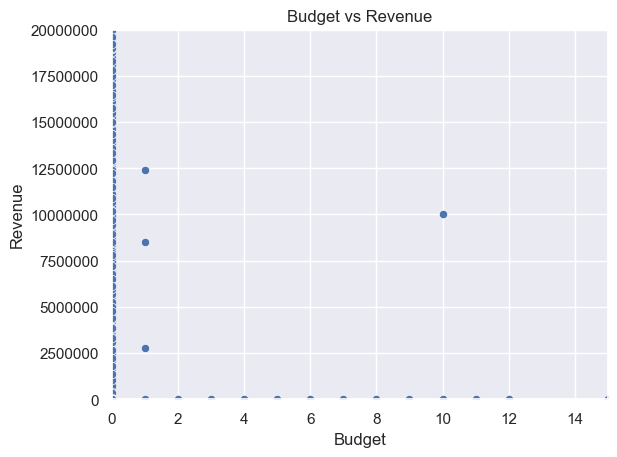

In [120]:
sns.set(context="notebook")
sns.scatterplot(df_movies, x="budget", y="revenue")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.title("Budget vs Revenue")
plt.xlim(0,15)
plt.ylim(0, 20000000)
plt.ticklabel_format(style='plain', axis='both')
